In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings

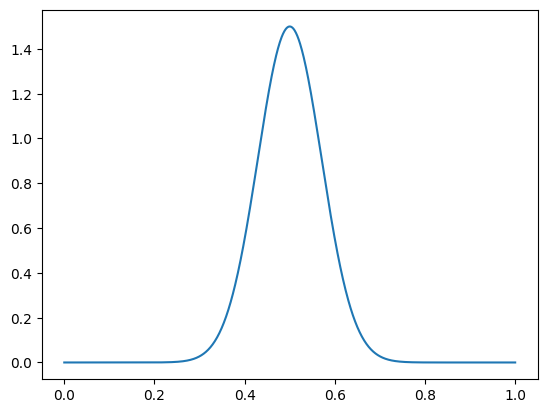

In [2]:
# Parameters
T = 1
x_max = 1
x_min = 0
dx = 1/1000
dt = 1/2000
grid_points = int((x_max - x_min)/dx) + 1
time_steps = int(T/dt) + 1

# Grid creation
x_grid = np.linspace(x_min, x_max, grid_points)
t_grid = np.linspace(0, T, time_steps)
grid = np.zeros((time_steps, grid_points))
error = np.zeros((time_steps, grid_points))

# Initial condition
grid[0, :] = 1.5*np.exp(-100*(x_grid - 0.5)**2)
error[0, :] = np.zeros(grid_points)
# grid[0, :] = - np.arctan((x_grid-0.5)/0.1)

plt.plot(x_grid, grid[0, :])
plt.show()


In [3]:
def finite_diff_spatial_derivative(grid_row, dx):
    der = np.zeros(len(grid_row))
    der[1:-1] = (grid_row[2:] - grid_row[:-2])/(2*dx)
    der[0] = 2*der[1] - der[2]
    der[-1] = 2*der[-2] - der[-3]
    return der

def finite_diff_spatial_double_derivative(grid_row, dx):
    der = np.zeros(len(grid_row))
    der[1:-1] = (grid_row[2:] - 2*grid_row[1:-1] + grid_row[:-2])/(dx**2)
    der[0] = 2*der[1] - der[2]
    der[-1] = 2*der[-2] - der[-3]
    return der

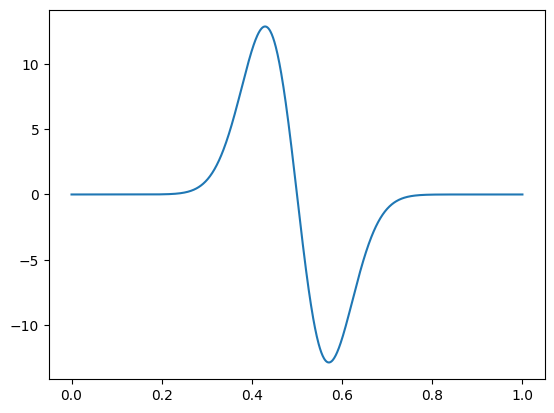

In [4]:
plt.plot(x_grid, finite_diff_spatial_derivative(grid[0, :], dx))
plt.show()

In [4]:
for t in t_grid[1:]:
    spatial_derivative = finite_diff_spatial_derivative(grid[int(t/dt) - 1, :], dx)
    spatial_double_derivative = finite_diff_spatial_double_derivative(grid[int(t/dt) - 1, :], dx)
#    analytical_derivative = -200 * (x_grid - 0.5) * np.exp(-1000 * (x_grid - 0.5)**2)
#    analytical_double_derivative = 40000 * (x_grid - 0.5)**2 * np.exp(-100 * (x_grid - 0.5)**2) - 200 * np.exp(-100 * (x_grid - 0.5)**2)

#    plt.plot(x_grid, spatial_derivative, label='Numerical Spatial Derivative')
#    plt.plot(x_grid, analytical_derivative, label='Analytical Derivative')
#    plt.legend()
#    plt.plot(x_grid, spatial_double_derivative, label='Numerical Spatial Double Derivative')
#    plt.plot(x_grid, analytical_double_derivative, label='Analytical Spatial Double Derivative')
#    plt.legend()
#    plt.show()

    temporal_derivative = - grid[int(t/dt) - 1, :] * spatial_derivative
    temporal_double_derivative = 2 * grid[int(t/dt) - 1, :] * spatial_derivative**2 + grid[int(t/dt) - 1, :]**2 * spatial_double_derivative

#    plt.plot(x_grid, temporal_derivative, label='Numerical Temporal Derivative')
#    plt.plot(x_grid, temporal_double_derivative, label='Numerical Temporal Double Derivative')
#    plt.legend()
#    plt.show()

    if t == dt:
        v_ext = grid[int(t/dt) - 1, :]
    else:
        v_ext = 1.5 * grid[int(t/dt) - 1, :] - 0.5 * grid[int(t/dt) - 2, :]

    v_ext_derivative = finite_diff_spatial_derivative(v_ext, dx)
    v_ext_double_derivative = finite_diff_spatial_double_derivative(v_ext, dx)

    n_iter = 10
    alpha = np.zeros((n_iter, len(x_grid)))
#    alpha[-1, :] = 4.03*dt*np.ones(len(x_grid)) # for fixed velocity
    for i, x in enumerate(x_grid):
        for j in range(1, n_iter):
            arg = x - alpha[j - 1, i]
            arg_idx = int(np.round((arg - x_min)/dx))
            residue = arg - (arg_idx * dx + x_min)
            arg_idx = arg_idx % len(x_grid)
            alpha[j, i] = dt * (v_ext[arg_idx] + v_ext_derivative[arg_idx] * residue + 0.5 * v_ext_derivative[arg_idx] * residue**2)

    # Plotting the evolution of alpha values for x indices from 400 to 600
#    from mpl_toolkits.mplot3d import Axes3D
#    import matplotlib.pyplot as plt

#    fig = plt.figure()
#    ax = fig.add_subplot(111, projection='3d')
#    X, Y = np.meshgrid(range(400, 601), range(n_iter))
#    Z = alpha[:, 400:601]

#    ax.plot_surface(X, Y, Z, cmap='viridis')
#    ax.set_xlabel('X index')
#    ax.set_ylabel('Iteration')
#    ax.set_zlabel('Alpha')
#    plt.title('Evolution of Alpha Values Over Iterations for X indices 400 to 600')
#    plt.show()

#    plt.plot(alpha[n_iter - 1, :])
#    p_displacement = np.round(alpha[n_iter - 1, :]/dx).astype(int)

#    plt.plot(p_displacement*dx)
#    plt.show()

#    euler_step = dt * (1 - (p_displacement * dx)/( dt * v_ext))

#    plt.plot(euler_step)
#    plt.show()

    # Interp SL method
    derivative_order = 9
    derivatives = np.zeros((derivative_order, len(x_grid)))
    derivatives[0, :] = grid[int(t/dt) - 1, :]
    for order in range(1, derivative_order):
        derivatives[order, :] = finite_diff_spatial_derivative(derivatives[order - 1, :], dx)
    for i, x in enumerate(x_grid):
        x_arg = x - alpha[n_iter - 1, i]
        frac_idx = (x_arg - x_min)/dx
        x_idx_round = int(np.round(frac_idx))
        t_idx = int(t/dt)

        x_step = (x_arg - x_min - x_idx_round*dx)

        #grid[t_idx, i] = grid[t_idx - 1, x_idx_round%len(x_grid)] + finite_diff_spatial_derivative(grid[t_idx - 1,:], dx)[ x_idx_round%len(x_grid)] * x_step #+ 0.5*finite_diff_spatial_derivative(finite_diff_spatial_derivative(grid[t_idx - 1,:], dx), dx)[ x_idx_round%len(x_grid)] * x_step**2
        grid[t_idx, i] = grid[t_idx - 1, x_idx_round%len(x_grid)]
        for power in range(1, derivative_order):
            grid[t_idx, i] += (1/math.factorial(power)) * derivatives[power, x_idx_round%len(x_grid)] * (x_step ** power)

        error[t_idx, i] = grid[t_idx, i] - 1.5*np.exp(-100 * (x_grid[i] - t_grid[t_idx]*grid[t_idx, i] - 0.5)**2)
#    for i, x in enumerate(x_grid):
#        x_idx = (i - p_displacement[i])%len(x_grid)
#        t_idx = int(t/dt)
#        grid[t_idx, i] = grid[t_idx - 1, x_idx] - euler_step[x_idx] * temporal_derivative[x_idx] + 0.5 * euler_step[x_idx]**2 * temporal_double_derivative[x_idx]
    
#    plt.plot(x_grid, grid[int(t/dt), :], label='t = ' + str(t))
#plt.legend()
#plt.show()


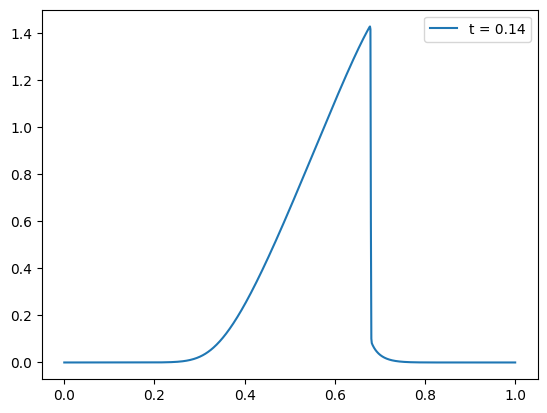

In [8]:
for t in t_grid[280:281]:
    plt.plot(x_grid, grid[int(t/dt), :], label='t = ' + str(t))
plt.legend()
plt.show()

In [13]:
t_idx = 350

print(np.argmax(grid[t_idx, :]))

print(grid[t_idx, np.argmax(grid[t_idx, :]) - 5:np.argmax(grid[t_idx, :]) + 6])


691
[1.28783901 1.29147693 1.295105   1.29871248 1.30217263 1.30391547
 1.28559961 0.43526178 0.05511235 0.0454626  0.04300142]


In [13]:
print(grid[50, 625:675])

[3.36218561 3.37381665 3.38541283 3.39697325 3.40849702 3.41998324
 3.43143101 3.44283945 3.45420754 3.46553418 3.47681812 3.48805797
 3.49925219 3.51039935 3.52149841 3.53254894 3.5435503  3.55450145
 3.56540113 3.57624787 3.58704003 3.5977759  3.60845374 3.61907182
 3.62962832 3.64012142 3.65054931 3.66091013 3.67120198 3.68142287
 3.69157071 3.7016433  3.71163835 3.72155343 3.73138603 3.7411335
 3.75079312 3.76036204 3.76983727 3.77921567 3.78849394 3.7976686
 3.80673603 3.81569238 0.2919912  0.81737151 0.43260996 0.39830392
 0.36888318 0.34343709]


In [16]:
from video_creator_1d import create_video

create_video(error[:, :], 'error_heck_order_8.mp4')

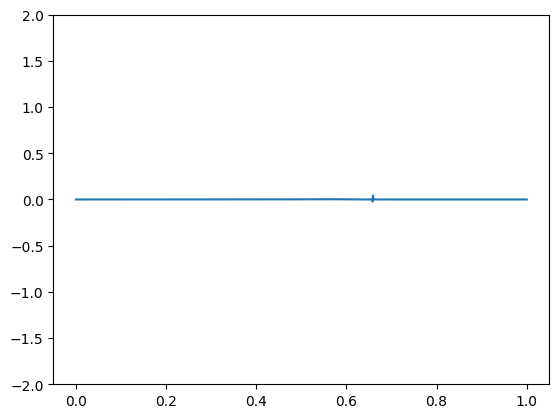

In [11]:
plt.plot(x_grid, error[200, :])
plt.ylim(-2, 2)
plt.show()